In [13]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


In [14]:
DATA_PATH = "DatasetMH.xlsx"   # <- pastikan namanya sama

df = pd.read_excel(DATA_PATH)

print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()


Shape: (2286, 4)
Columns: ['Text', 'Emoticons', 'Polarity', 'Stigma']


,Text,Emoticons,Polarity,Stigma
0,¡Animo guapa! Aquí tienes a tu familia virtual...,❤️😍,Positiva,No
1,¡Nos alegra tenerte nuevamente por aquí!.Te ec...,❤️❤️❤️❤️,Positiva,No
2,"@dulceida Puedes con todo, pero no todo al mis...","❤️❤️❤️❤️😘😘😘""",Positiva,No
3,@mpombor mucho ánimo y estamos contigo muchos...,NaN,Positiva,No
4,"@tamara_gorro GUAPA,no te conozco pero me tran...",😘😘😘,Positiva,No


In [15]:
def detect_text_column(df):
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    if not obj_cols:
        raise ValueError("Tidak ada kolom teks (dtype object). Cek file Excel-nya.")
    
    avg_len = {}
    for c in obj_cols:
        s = df[c].dropna().astype(str)
        if len(s) == 0:
            avg_len[c] = 0
        else:
            avg_len[c] = s.str.len().mean()
    text_col = max(avg_len, key=avg_len.get)
    return text_col, avg_len

TEXT_COL, lens = detect_text_column(df)
print("Detected TEXT_COL:", TEXT_COL)
print("Avg text lengths (top 5):", sorted(lens.items(), key=lambda x: x[1], reverse=True)[:5])

def detect_label_candidates(df, text_col, max_unique=20):
    obj_cols = [c for c in df.columns if df[c].dtype == "object" and c != text_col]
    candidates = []
    for c in obj_cols:
        nunq = df[c].nunique(dropna=True)
        if 2 <= nunq <= max_unique:
            candidates.append((c, nunq))
    candidates = sorted(candidates, key=lambda x: x[1])
    return candidates

label_candidates = detect_label_candidates(df, TEXT_COL, max_unique=30)
print("Label candidates:", label_candidates)


Detected TEXT_COL: Text
Avg text lengths (top 5): [('Text', np.float64(108.15135608048993)), ('Polarity', np.float64(8.378390201224846)), ('Emoticons', np.float64(3.8169398907103824)), ('Stigma', np.float64(2.0))]
Label candidates: [('Stigma', 2), ('Polarity', 3)]


In [16]:
def pick_label(df, candidates):
    # prioritas nama umum
    lower_map = {c.lower(): c for c in df.columns}
    for key in ["polarity", "sentiment", "stigma", "emotion", "label", "class"]:
        for c in df.columns:
            if key in c.lower():
                return c
    if not candidates:
        raise ValueError("Tidak menemukan kandidat label. Tolong pilih manual dari df.columns.")
    return candidates[0][0]  # unik paling kecil

LABEL_COL = pick_label(df, label_candidates)
print("Chosen LABEL_COL:", LABEL_COL)

# cek distribusi label
df[LABEL_COL].value_counts(dropna=False).head(20)


Chosen LABEL_COL: Polarity


Polarity
Positiva         1526
Negativa          587
Indeterminado     173
Name: count, dtype: int64

In [17]:
df = df[[TEXT_COL, LABEL_COL]].copy()

# drop missing
df[TEXT_COL] = df[TEXT_COL].astype(str)
df[LABEL_COL] = df[LABEL_COL].astype(str)

df[TEXT_COL] = df[TEXT_COL].str.strip()
df[LABEL_COL] = df[LABEL_COL].str.strip()

# hapus baris kosong
df = df[(df[TEXT_COL] != "") & (df[LABEL_COL] != "")]
df = df[df[LABEL_COL].str.lower() != "nan"]

print("After cleaning:", df.shape)
print(df[LABEL_COL].value_counts().head(20))


After cleaning: (2286, 2)
Polarity
Positiva         1526
Negativa          587
Indeterminado     173
Name: count, dtype: int64


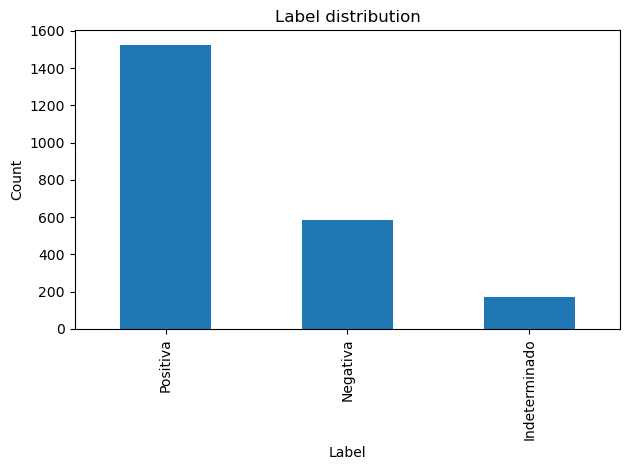

In [18]:
plt.figure()
df[LABEL_COL].value_counts().plot(kind="bar")
plt.title("Label distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


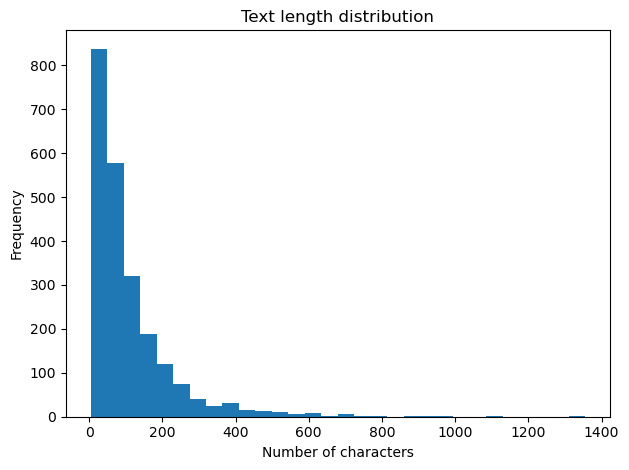

In [19]:
text_len = df[TEXT_COL].astype(str).str.len()

plt.figure()
plt.hist(text_len, bins=30)
plt.title("Text length distribution")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


/var/folders/lz/6kyphf6d53bcl62l5rk5nl2r0000gn/T/ipykernel_92717/2825585362.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top_labels, vert=True)


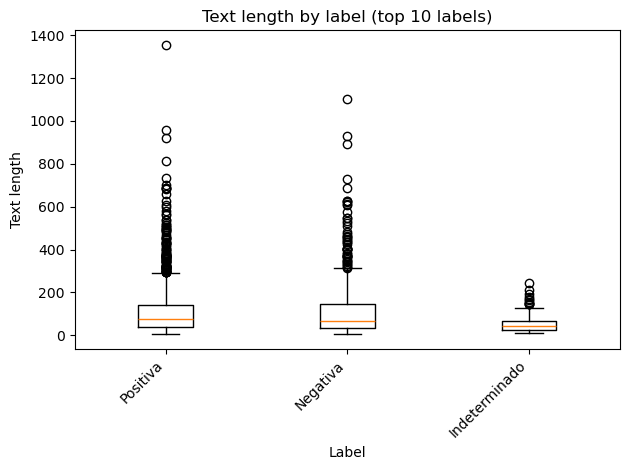

In [20]:
# ambil max 10 label biar rapi
top_labels = df[LABEL_COL].value_counts().head(10).index
tmp = df[df[LABEL_COL].isin(top_labels)].copy()
tmp["text_len"] = tmp[TEXT_COL].astype(str).str.len()

data = [tmp[tmp[LABEL_COL]==lab]["text_len"].values for lab in top_labels]

plt.figure()
plt.boxplot(data, labels=top_labels, vert=True)
plt.title("Text length by label (top 10 labels)")
plt.xlabel("Label")
plt.ylabel("Text length")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


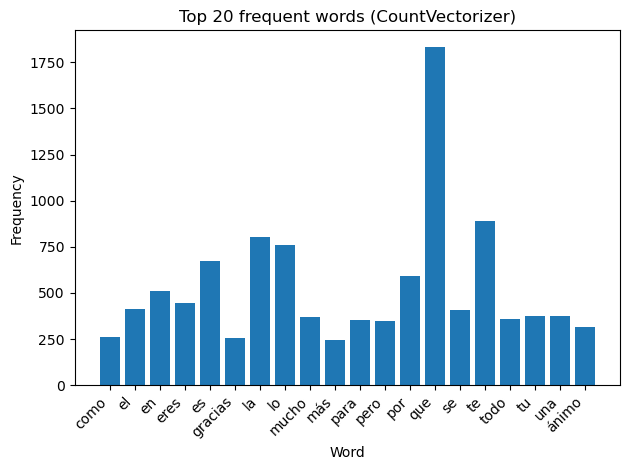

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words="english", max_features=20)
X_counts = cv.fit_transform(df[TEXT_COL])
words = cv.get_feature_names_out()
freq = np.asarray(X_counts.sum(axis=0)).ravel()

plt.figure()
plt.bar(words, freq)
plt.title("Top 20 frequent words (CountVectorizer)")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [22]:
X = df[TEXT_COL].values
y = df[LABEL_COL].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", len(X_train), "Test:", len(X_test))


Train: 1828 Test: 458


In [23]:
lr_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1,2),
        min_df=2,
        max_df=0.95
    )),
    ("clf", LogisticRegression(
        max_iter=3000,
        class_weight="balanced"
    ))
])

lr_pipe.fit(X_train, y_train)
pred_lr = lr_pipe.predict(X_test)

print("LR Accuracy:", accuracy_score(y_test, pred_lr))
print("LR F1 (macro):", f1_score(y_test, pred_lr, average="macro"))
print(classification_report(y_test, pred_lr))


LR Accuracy: 0.8318777292576419
LR F1 (macro): 0.7051307599715796
               precision    recall  f1-score   support

Indeterminado       0.52      0.40      0.45        35
     Negativa       0.72      0.82      0.76       117
     Positiva       0.91      0.89      0.90       306

     accuracy                           0.83       458
    macro avg       0.72      0.70      0.71       458
 weighted avg       0.83      0.83      0.83       458



In [24]:
svm_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1,2),
        min_df=2,
        max_df=0.95
    )),
    ("clf", LinearSVC(class_weight="balanced"))
])

svm_pipe.fit(X_train, y_train)
pred_svm = svm_pipe.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, pred_svm))
print("SVM F1 (macro):", f1_score(y_test, pred_svm, average="macro"))
print(classification_report(y_test, pred_svm))


SVM Accuracy: 0.8558951965065502
SVM F1 (macro): 0.7195637577803183
               precision    recall  f1-score   support

Indeterminado       0.63      0.34      0.44        35
     Negativa       0.80      0.80      0.80       117
     Positiva       0.89      0.93      0.91       306

     accuracy                           0.86       458
    macro avg       0.77      0.69      0.72       458
 weighted avg       0.85      0.86      0.85       458



In [25]:
param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2, 3],
    "clf__C": [0.5, 1.0, 2.0, 4.0]
}

grid = GridSearchCV(
    lr_pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_lr = grid.best_estimator_

print("Best params:", grid.best_params_)
pred_best = best_lr.predict(X_test)

print("Tuned LR Accuracy:", accuracy_score(y_test, pred_best))
print("Tuned LR F1 (macro):", f1_score(y_test, pred_best, average="macro"))
print(classification_report(y_test, pred_best))


Best params: {'clf__C': 2.0, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Tuned LR Accuracy: 0.8362445414847162
Tuned LR F1 (macro): 0.7024434670576213
               precision    recall  f1-score   support

Indeterminado       0.52      0.37      0.43        35
     Negativa       0.74      0.81      0.77       117
     Positiva       0.90      0.90      0.90       306

     accuracy                           0.84       458
    macro avg       0.72      0.69      0.70       458
 weighted avg       0.83      0.84      0.83       458



<Figure size 640x480 with 0 Axes>

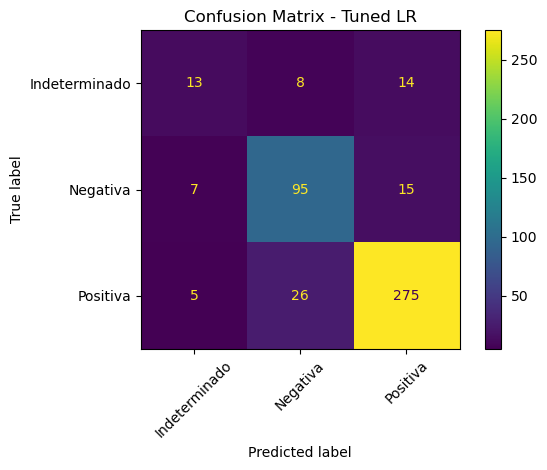

In [26]:
cm = confusion_matrix(y_test, pred_best, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))

plt.figure()
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Tuned LR")
plt.tight_layout()
plt.show()


In [27]:
results = pd.DataFrame({
    "Model": [
        "TFIDF + Logistic Regression (baseline)",
        "TFIDF + Linear SVM",
        "TFIDF + Logistic Regression (tuned)"
    ],
    "Accuracy": [
        accuracy_score(y_test, pred_lr),
        accuracy_score(y_test, pred_svm),
        accuracy_score(y_test, pred_best)
    ],
    "F1_macro": [
        f1_score(y_test, pred_lr, average="macro"),
        f1_score(y_test, pred_svm, average="macro"),
        f1_score(y_test, pred_best, average="macro")
    ]
})

results.sort_values("F1_macro", ascending=False)


,Model,Accuracy,F1_macro
1,TFIDF + Linear SVM,0.855895,0.719564
0,TFIDF + Logistic Regression (baseline),0.831878,0.705131
2,TFIDF + Logistic Regression (tuned),0.836245,0.702443


In [31]:
import joblib

joblib.dump(svm_pipe, "model_svm.pkl")


['model_svm.pkl']